In [ ]:
from pathlib import Path

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, TangentODE
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import RandomSampleBatching
from dynamics_discovery.neighborhood import NeighborhoodSegmentLoader
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [ ]:
noise = 0.02
downsample = 2
dataset, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(5000, 5000, 3)

In [ ]:
loader = NeighborhoodSegmentLoader(
    dataset,
    segment_length=2,
    num_neighbors=30,
    batch_strategy=RandomSampleBatching(2048),
)
loader_state = loader.init()

Creating KDTree for neighbor search


TypeError: NeighborhoodSegmentLoader._create_tree() takes 1 positional argument but 2 were given

In [4]:
%%timeit
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

2.99 s ± 56.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
loader_state

((24995000,
  Array((), dtype=key<fry>) overlaying:
  [0 0]),
 0)

In [6]:
batch, loader_state = loader.load_batch(loader_state)

In [7]:
batch[0][2].shape

(2,)

In [73]:
import numpy as np
from sklearn.neighbors import KDTree


segment_length = 2

u_dataset_flat = dataset.u[:, : -segment_length + 1].reshape(-1, dataset.u.shape[-1])
u_dataset_flat_downsample = u_dataset_flat[::200]
tree = KDTree(u_dataset_flat_downsample)


In [9]:
u_dataset_flat_downsample.dtype

dtype('float64')

In [72]:
len(u_dataset_flat) * 17 / (4096 * 64 * 4) / 60

6.753842035929362

In [74]:
idx_radius, dist = tree.query_radius(u_dataset_flat, 0.07, return_distance=True)

In [77]:
result = [
    idx_[d > 0.05] if len(idx_[d > 0.05]) > 0 else np.array([i])
    for i, (idx_, d) in enumerate(zip(idx_radius, dist))
]

In [78]:
lens = np.array([len(r) for r in result])
min(lens)

np.int64(1)

In [34]:
result[0]

array([ 20229,  50712, 111480,  36612,  57813,  43381,  85489, 120685,
        73505,   1661, 102814,  83985,  65824,  46095,   9946,  91075,
        66702,   5685, 103460,  60664,    877, 121246,  78182,  17186,
        23875,   2122, 119460,  52931,  22943,  74305, 109961, 117355,
        20326,  96958,  37776,  58907,  44588,   4317,   7278,  87304,
        59005, 103896, 101704,  72333,  21825,  43656,  55131,  83775,
        52218, 122496,  22163,  78304,  31902,  51122,  60385,  64967,
        47368,  53905,  91022,  36890, 113901,  21308,  89558, 115121,
        29239, 120908, 111188, 102526,  18528,   1192, 121973,  67356,
        25361,  21491,  56951,  85310,  12067, 117409, 110362,  42362,
        98641,  24484, 120636,  44707,  22141, 121954,  60663,  74129,
        81294,  83529,  11075,  67229,   1876, 124192,  93781,  20395,
        58428, 109380,  30784,  65347,  80141,  40917,  65839,   1028,
        44002,   9862,  98894,  25000,  93566,  58526, 105945,  70721,
      

In [80]:
len(lens[lens < 2]) / len(lens)

0.006365713142628526

In [92]:
results_flat = np.concatenate(result)
results_flat.shape

(1171806856,)

In [101]:
split_indices = np.concatenate((np.zeros_like(lens, shape=1), np.cumsum(lens)), axis=0)

In [ ]:
from more_itertools import pairwise


results_load = [results_flat[start:end] for start, end in pairwise(split_indices)]

In [83]:
# %%timeit
rng = np.random.default_rng()
batch_inds = rng.integers(0, len(u_dataset_flat), size=2048)
sampled = [np.random.choice(result[i], 30, replace=True) for i in batch_inds]

In [103]:
all(np.array_equal(r, r_load) for r, r_load in zip(result, results_load))

True

In [104]:
np.savez(
    datadir
    / "lorenz63_large_neighbor_indices_noise=0.05_downsample=200_rmin=0.05_rmax=0.07.npz",
    neighbor_indices_flat=results_flat,
    slice_indices=split_indices,
)

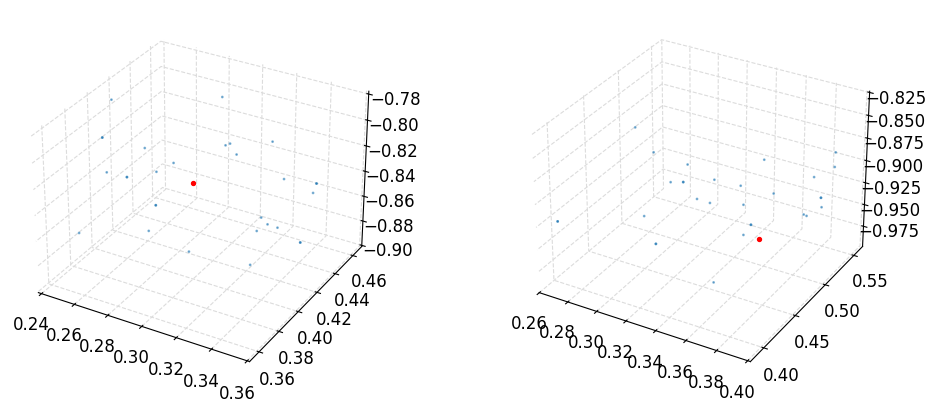

In [87]:
test_ind = 80

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 1.0, "alpha": 0.8}
# ax.scatter(*u_dataset_flat[::100].T, **scatter_kwargs)
batch_ind, time_ind = np.divmod(batch_inds[test_ind], dataset.u.shape[1] - 2 + 1)
u0 = dataset.u[batch_ind, time_ind]
u1 = dataset.u[batch_ind, time_ind + 1]
axes[0].scatter(*u0.T, color="red", s=8.0)
axes[1].scatter(*u1.T, color="red", s=8.0)

batch_ind, time_ind = np.divmod(sampled[test_ind] * 200, dataset.u.shape[1] - 2 + 1)
u_nn0 = dataset.u[batch_ind, time_ind]
u_nn1 = dataset.u[batch_ind, time_ind + 1]
axes[0].scatter(*u_nn0.T, s=1.0, alpha=0.5)
axes[1].scatter(*u_nn1.T, s=1.0, alpha=0.5)

In [88]:
jnp.sqrt(jnp.sum((u_nn0 - u0) ** 2, axis=-1))

Array([0.05041673, 0.06253043, 0.06586614, 0.05274758, 0.05227532,
       0.05143719, 0.06694673, 0.0589323 , 0.05579684, 0.0624322 ,
       0.06327148, 0.05404035, 0.06727005, 0.06691263, 0.06327148,
       0.06742548, 0.06205172, 0.06691263, 0.05974414, 0.05909976,
       0.05185605, 0.05714418, 0.05948838, 0.05170196, 0.05579684,
       0.05962955, 0.06727005, 0.06742548, 0.06944609, 0.05134483],      dtype=float64)

In [89]:
jnp.sqrt(jnp.sum((u_nn1 - u1) ** 2, axis=-1))

Array([0.10443157, 0.05333385, 0.10831492, 0.05959843, 0.08847491,
       0.04049223, 0.07114895, 0.07046731, 0.12481013, 0.07584741,
       0.09616202, 0.06085424, 0.09729133, 0.06632589, 0.09616202,
       0.0687123 , 0.09115151, 0.06632589, 0.04853189, 0.0738242 ,
       0.05309728, 0.07851953, 0.06915037, 0.06812753, 0.12481013,
       0.01426732, 0.09729133, 0.0687123 , 0.12422423, 0.03380841],      dtype=float64)

In [90]:
M_pred = tangent_evolution_matrix(lorenz_scaled, u0, dataset.t[0, 0], dataset.t[0, 1])
M_pred

Array([[ 0.8261385 ,  0.22584157, -0.00587183],
       [ 0.20860171,  1.00403724, -0.05074118],
       [ 0.07835113,  0.06515353,  0.94092919]], dtype=float64)

In [91]:
du0 = u_nn0 - u0
du1 = u_nn1 - u1
jnp.mean((M_pred.T @ du0.T - du1.T) ** 2)

Array(0.00152632, dtype=float64)

In [69]:
idx_weird = np.argmin(np.asarray(lens))

In [13]:
u_dataset_flat[idx_weird]

array([-2.35720119, -1.71811863,  2.38792835])

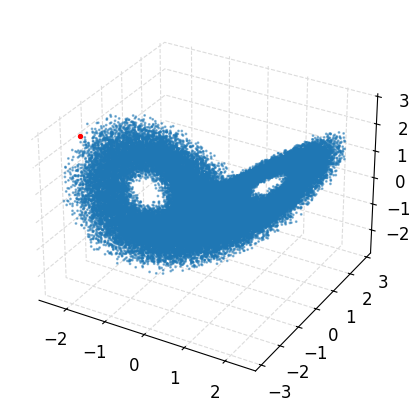

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 1.0, "alpha": 0.8}
# ax.scatter(*u_dataset_flat[::100].T, **scatter_kwargs)
ax.scatter(*u_dataset_flat[idx_weird].T, color="red", s=8.0)
ax.scatter(*u_dataset_flat[::500].T, s=1.0, alpha=0.5)

(array([22., 30., 15., 14., 10.,  6.,  8., 14., 12., 13., 21., 20., 37.,
        33., 31., 37., 34., 37., 34., 35., 45., 54., 43., 65., 50., 64.,
        64., 62., 55., 42., 45., 45., 31., 41., 29., 29., 24., 33., 26.,
        24., 31., 30., 32., 13., 14., 32., 17., 18., 20., 20., 22., 17.,
        22., 17., 23., 20., 14., 15.,  6., 17.,  7.,  8.,  7.,  8., 18.,
        12.,  8.,  5.,  9.,  9., 14.,  7., 12.,  9.,  9.,  9., 10.,  9.,
         5.,  9.,  6.,  8.,  8., 10.,  6., 14.,  4., 11.,  5.,  6.,  8.,
         8.,  3.,  4.,  8.,  6.,  8.,  3.,  1.,  3.]),
 array([  6716.  ,  16365.48,  26014.96,  35664.44,  45313.92,  54963.4 ,
         64612.88,  74262.36,  83911.84,  93561.32, 103210.8 , 112860.28,
        122509.76, 132159.24, 141808.72, 151458.2 , 161107.68, 170757.16,
        180406.64, 190056.12, 199705.6 , 209355.08, 219004.56, 228654.04,
        238303.52, 247953.  , 257602.48, 267251.96, 276901.44, 286550.92,
        296200.4 , 305849.88, 315499.36, 325148.84, 334798.32, 3

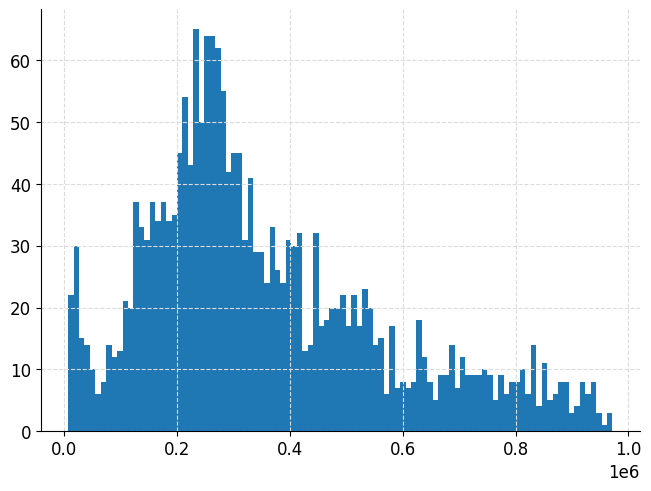

In [47]:
lens = [len(r) for r in result]
plt.hist(lens, bins=100)

In [9]:
sample_idx = 30


u_center = batch[0][1][sample_idx, 0]

u_radius = batch[0][2][sample_idx, 0]
u_center1 = batch[0][1][sample_idx, 1]
u_radius1 = batch[0][2][sample_idx, 1]

IndexError: Too many indices: 1-dimensional array indexed with 2 regular indices.

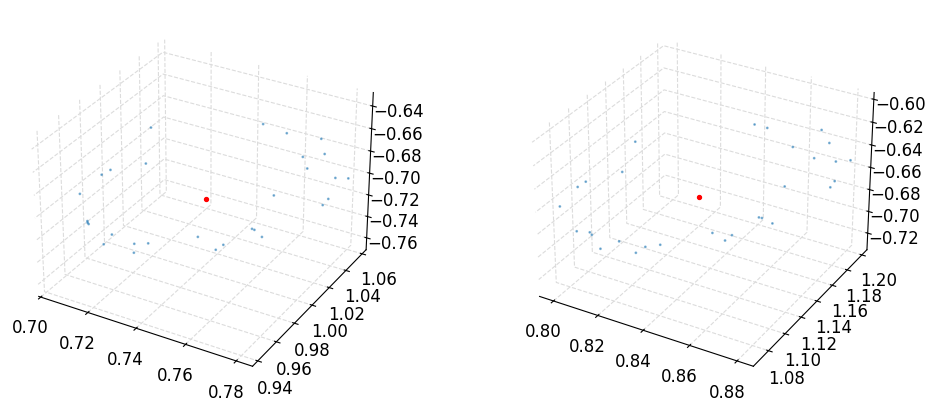

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 1.0, "alpha": 0.8}
# ax.scatter(*u_dataset_flat[::100].T, **scatter_kwargs)
axes[0].scatter(*u_center.T, color="red", s=8.0)
axes[0].scatter(*u_radius.T, s=1.0, alpha=0.5)

axes[1].scatter(*u_center1.T, color="red", s=8.0)
axes[1].scatter(*u_radius1.T, s=1.0, alpha=0.5)

In [8]:
du0 = u_radius - u_center
du1 = u_radius1 - u_center1
Z = jnp.concatenate((du0, du1), axis=-1).T


[0.24872274 0.17846008 0.12928696]
[0.40083514 0.25255812 0.12186825]
[[0.40083514 0.         0.        ]
 [0.         0.25255812 0.        ]
 [0.         0.         0.        ]]


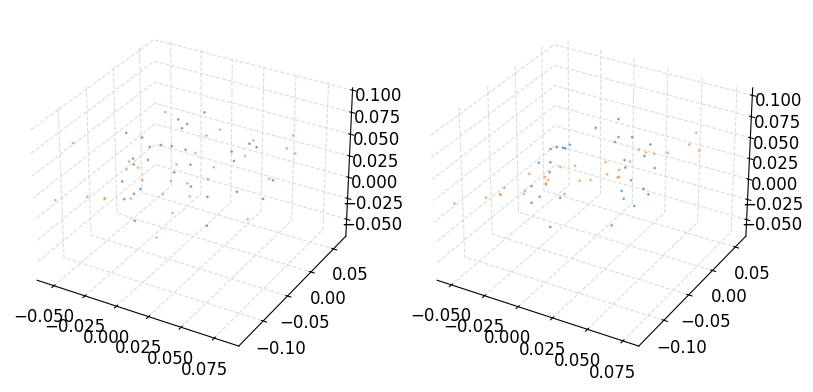

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"projection": "3d"})
axes[0].scatter(*du0.T, alpha=0.5, s=1)
axes[0].scatter(*du1.T, alpha=0.5, s=1)


u, s, v = jnp.linalg.svd(du0.T, full_matrices=False)
print(s)
du0_noise_trunc = (u @ jnp.diag(jnp.asarray([s[0], s[1], 0.0])) @ v).T

u, s, v = jnp.linalg.svd(du1.T, full_matrices=False)
print(s)
du1_noise_trunc = (u @ jnp.diag(jnp.asarray([s[0], s[1], 0.0])) @ v).T
print(jnp.diag(jnp.asarray([s[0], s[1], 0.0])))
axes[1].scatter(*du0_noise_trunc.T, alpha=0.5, s=1)
axes[1].scatter(*du1_noise_trunc.T, alpha=0.5, s=1)

In [11]:
U, Sigma, Vh = jnp.linalg.svd(Z, full_matrices=False)
Sigma

Array([0.44692642, 0.29844795, 0.15389085, 0.13314493, 0.10375195,
       0.09350707], dtype=float64)

In [12]:
Q = Vh[:3].T
print(Q.shape)

du0_proj = du0.T @ Q
du1_proj = du1.T @ Q

(30, 3)


In [13]:
Z_trunc = jnp.concatenate((du0_noise_trunc, du1_noise_trunc), axis=-1).T
U, Sigma, Vh = jnp.linalg.svd(Z_trunc, full_matrices=False)
print(Sigma)

Q = Vh[:3].T

du0_proj_trunc = du0_noise_trunc.T @ Q
du1_proj_trunc = du1_noise_trunc.T @ Q

[4.46084239e-01 2.98324659e-01 1.30663284e-01 1.14471722e-01
 6.71670670e-18 2.46049031e-18]


In [14]:
du0_proj

Array([[ 0.08959884,  0.0482307 ,  0.06731655],
       [ 0.13495295,  0.14009701, -0.09261549],
       [-0.13242593,  0.07919235,  0.08158222]], dtype=float64)

In [15]:
du1_proj

Array([[ 0.05276407,  0.15958324, -0.01089353],
       [ 0.36148768,  0.01912245,  0.0580105 ],
       [-0.15002985,  0.18712002,  0.02082548]], dtype=float64)

In [158]:
u_center.shape

(1, 3)

In [17]:
M_pred = tangent_evolution_matrix(
    lorenz_scaled, u_center, dataset.t[0, 0], dataset.t[0, 1]
)
M_pred

Array([[ 0.82169242,  0.22482386, -0.01495178],
       [ 0.16559035,  0.99060339, -0.12829409],
       [ 0.18096748,  0.16271647,  0.93229397]], dtype=float64)

In [18]:
M_tls = jnp.matmul(du1_proj, jnp.linalg.pinv(du0_proj))
M_tls

Array([[ 0.2349825 ,  0.75730241,  0.53229975],
       [ 2.29190502,  0.00884658, -1.17002596],
       [-0.53136174,  0.68613621,  1.47264635]], dtype=float64)

In [19]:
M_tls_trunc = jnp.matmul(du1_proj_trunc, jnp.linalg.pinv(du0_proj_trunc))
M_tls_trunc

Array([[ 0.22865338,  0.76268608,  0.65104862],
       [ 0.32470956,  0.69883095, -0.93327618],
       [ 0.07512744,  0.47282767,  1.28839334]], dtype=float64)

In [20]:
jnp.mean((M_pred.T @ du0_proj - du1_proj) ** 2)

Array(0.01346057, dtype=float64)

In [21]:
jnp.mean((M_pred.T @ du0_proj_trunc - du1_proj_trunc) ** 2)

Array(0.01354413, dtype=float64)

In [22]:
jnp.mean((M_pred.T @ du0.T - du1.T) ** 2)

Array(0.00184891, dtype=float64)

In [26]:
U[3:, 0:3]

Array([[ 0.35846369, -0.26661142,  0.39890037],
       [ 0.61949792,  0.08306139, -0.38337383],
       [ 0.0556229 ,  0.61688501, -0.23490777]], dtype=float64)

In [27]:
U[0:3, 0:3]

Array([[ 0.27637605, -0.34652691,  0.41494274],
       [ 0.61645076, -0.0056849 , -0.1903419 ],
       [ 0.1680385 ,  0.64912158,  0.6559831 ]], dtype=float64)

In [153]:
jnp.matmul(U[3:, 0:3], jnp.linalg.pinv(U[0:3, 0:3]))

Array([[ 0.88337265,  0.1772122 ,  0.05390202],
       [-0.29235387,  1.15194881, -0.02555865],
       [-0.96957316,  0.41348624,  0.42213639]], dtype=float64)

## Prototyping with jagged arrays

In [23]:
batch_size_test = 2048
u_cpu = dataset.u[:batch_size_test, 0]
idx_radius, dist = tree.query_radius(u_cpu, 0.07, return_distance=True)
idx_radius

array([array([10107703,  4282854, 15043383, ..., 22513775, 14466828, 21991722],
             shape=(19604,))                                                   ,
       array([ 2868479,   441461, 10141258, ...,  7701575, 13951356, 10688354],
             shape=(4027,))                                                    ,
       array([14077237, 19606211,  5791886, ...,  1517220,  3428804, 14502568],
             shape=(10552,))                                                   ,
       ...,
       array([11713197, 14704152, 21749164, ..., 20615479,  2622155, 19280932],
             shape=(16450,))                                                   ,
       array([13513281,   356298, 11023075, ..., 16635548, 14346257,  3795279],
             shape=(15631,))                                                   ,
       array([  839283, 15618692, 22286053, ..., 20885964, 23576260,  7490107],
             shape=(10543,))                                                   ],
      shape=(2048,), 

In [ ]:
import numpy as np


np.sort(idx_radius[0])

array([       0,      694,      724, ..., 24989650, 24989680, 24993960],
      shape=(19604,))

In [7]:
import numpy as np


rng = np.random.default_rng(seed=0)

In [ ]:
rng = np.random.default_rng(seed=0)
result = np.stack(
    [rng.choice(idx_[d > r_min], 50) for idx_, d in zip(idx_radius, dist)],
    axis=0,
)
result.shape

(2048, 50)

## Try SNN

In [67]:
import faiss
import numpy as np


quantizer = faiss.IndexFlatL2(u_dataset_flat.shape[1])
index = faiss.IndexIVFFlat(quantizer, u_dataset_flat.shape[1], 10000)
index.train(u_dataset_flat.astype(np.float32))
index.add(u_dataset_flat.astype(np.float32))
index.nprobe = 10
batch_size_test = 4096 * 64
u_cpu = u_dataset_flat[:batch_size_test]

In [66]:
u_cpu.shape

(5000, 3)

In [68]:
lims, D, I = index.range_search(u_cpu, 0.3**2)

: 

In [38]:
I[lims[0] : lims[1]]

array([       0,      694,     7008, ..., 24859769, 24886544, 24975598],
      shape=(18731,))

In [35]:
np.sqrt(D[lims[0] : lims[1]])

array([0.        , 0.02080864, 0.03813111, ..., 0.03080941, 0.03659623,
       0.01840945], shape=(3105,), dtype=float32)

In [55]:
query_radius_jit = eqx.filter_jit(snn_model.query_radius)

In [56]:
%%timeit
inds, dists = query_radius_jit(u_cpu[0], 0.07, return_distance=True)


IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(JitTracer<int32[]>, JitTracer<int32[]>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [154]:
u_noise_all = jnp.concatenate((jnp.expand_dims(u_noise, axis=-2), u_nn_noise), axis=-2)
u_mean = jnp.mean(u_noise_all, axis=-2, keepdims=True)
u_covar = jnp.mean(
    jax.vmap(jax.vmap(jax.vmap(jnp.linalg.outer)))(
        u_noise_all - u_mean, u_noise_all - u_mean
    ),
    axis=-3,
)
eigvals, eigvecs = jnp.linalg.eigh(u_covar)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [138]:
u_noise_all.shape

(4, 2, 501, 3)

In [139]:
u_resid = u_noise_all - u_mean
u_resid.shape

(4, 2, 501, 3)

In [140]:
eigvecs.shape

(4, 2, 3, 3)

In [141]:
eigvals

Array([[[0.00016807, 0.00018852, 0.00020288],
        [0.00233619, 0.00458253, 0.00576165]],

       [[0.00011969, 0.0001341 , 0.00013593],
        [0.00238312, 0.00436265, 0.00496431]],

       [[0.00012533, 0.00014053, 0.00015414],
        [0.00268185, 0.00528321, 0.00661036]],

       [[0.00011479, 0.00011864, 0.00013462],
        [0.00220165, 0.00473042, 0.00555412]]], dtype=float64)

In [142]:
eigvecs[0, 0, 1]

Array([-0.20306241,  0.83703282,  0.50807648], dtype=float64)

In [143]:
jnp.expand_dims(eigvecs[..., 0], axis=-2).shape

(4, 2, 1, 3)

In [147]:
correction = -jnp.expand_dims(
    jnp.linalg.vecdot(u_resid, jnp.expand_dims(eigvecs[..., 0], axis=-2)), axis=-1
) * jnp.expand_dims(eigvecs[..., 0], axis=-2)
u_noise_corr = u_noise_all + correction

In [149]:
u_noise_corr = (
    jnp.expand_dims(
        jnp.linalg.vecdot(u_resid, jnp.expand_dims(eigvecs[..., 0], axis=-2)), axis=-1
    )
    * jnp.expand_dims(eigvecs[..., 0], axis=-2)
    + jnp.expand_dims(
        jnp.linalg.vecdot(u_resid, jnp.expand_dims(eigvecs[..., 1], axis=-2)), axis=-1
    )
    * jnp.expand_dims(eigvecs[..., 1], axis=-2)
    + u_noise_all
)

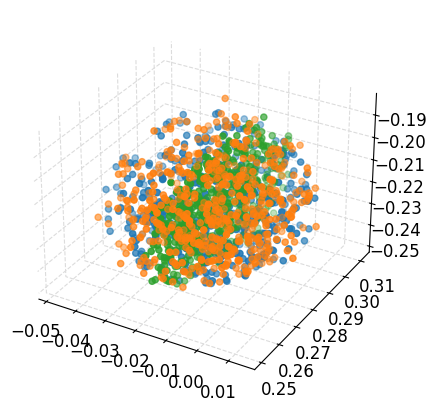

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
ax.scatter(*u_nn0.T)
ax.scatter(*u_nn_noise[sample_idx, 0].T)
ax.scatter(*u_noise_corr[sample_idx, 0, 1:].T)

In [61]:
def tangent_evolution_matrix(
    ode: AbstractODE,
    x: Float[Array, " dim"],
    t0: float,
    t1: float,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    stepsize_controller: dfx.AbstractAdaptiveStepSizeController = dfx.PIDController(
        rtol=1e-7, atol=1e-9
    ),
):
    tangent_ode = TangentODE(ode)
    u0 = (x, jnp.identity(ode.dim))

    sol = dfx.diffeqsolve(
        dfx.ODETerm(tangent_ode.rhs),
        solver,
        t0,
        t1,
        None,
        u0,
        None,
        saveat=dfx.SaveAt(t1=True),
        stepsize_controller=stepsize_controller,
    )
    _, M_t = sol.ys
    return M_t[0]  # remove time dimension

In [30]:
batch[2].shape

(1024, 2, 50, 3)

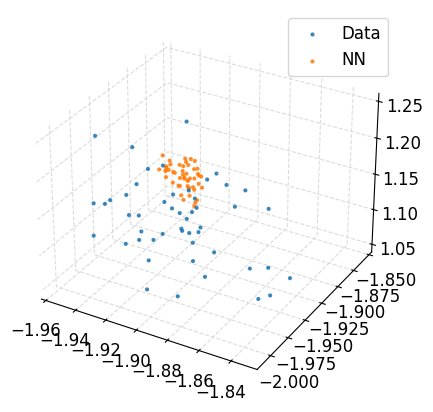

In [31]:
sample_idx = 0

u0 = batch[1][sample_idx, 0]
u_nn0 = batch[2][sample_idx, 0]

u1 = batch[1][sample_idx, 1]
u_nn1 = batch[2][sample_idx, 1]

M = tangent_evolution_matrix(lorenz_scaled, u0, *batch[0][sample_idx])

u_nn1_pred = jnp.squeeze(M @ jnp.expand_dims(u_nn0 - u0, axis=-1)) + u1

fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*u_nn1.T, label="Data", **scatter_kwargs)
ax.scatter(
    *u_nn1_pred.T,
    label="NN",
    **scatter_kwargs,
)
ax.legend()

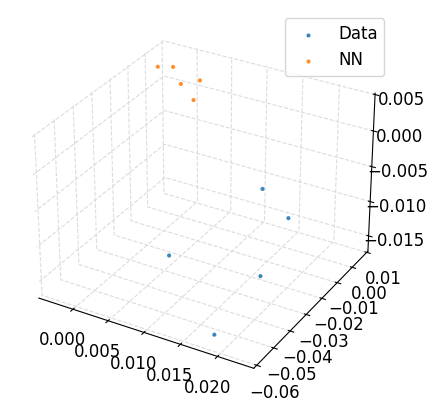

In [32]:
du0 = jnp.expand_dims(u_nn0 - u0, axis=-1)
du0_mean = jnp.mean(du0.reshape(10, -1, 3, 1), axis=0)


du1 = jnp.expand_dims(u_nn1 - u1, axis=-1)
du1_mean = jnp.squeeze(jnp.mean(du1.reshape(10, -1, 3, 1), axis=0))

du_nn1_mean_pred = jnp.squeeze(M @ du0_mean)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*du1_mean.T, label="Data", **scatter_kwargs)
ax.scatter(
    *du_nn1_mean_pred.T,
    label="NN",
    **scatter_kwargs,
)
ax.legend()

In [24]:
u_nn1.shape

(50, 3)

In [140]:
tangent_evolution_matrix(lorenz_scaled, u0, *batch[0][sample_idx])

Array([[-0.50601074,  1.25011664, -2.04192358],
       [-0.71753571,  1.72945967, -2.95083028],
       [-0.4385832 ,  1.27777787, -1.41522471]], dtype=float64)

In [141]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, batch[0][0, 1] - batch[0][0, 0]
    )
)(batch[1][:, 0])

In [142]:
du = jnp.permute_dims(batch[2] - jnp.expand_dims(batch[1], axis=-2), axes=(0, 1, 3, 2))
du.shape

(1024, 2, 3, 30)

In [143]:
M_naive = jnp.matmul(du[:, 1], jnp.linalg.pinv(du[:, 0]))
M_naive.shape

(1024, 3, 3)

In [144]:
jnp.linalg.pinv(du[:, 0])

Array([[[ -0.0809918 ,   0.3437666 ,   1.10603115],
        [ -2.07956028,   3.15355796,  -0.93637402],
        [ -4.68444028,   2.00616249,   0.68229178],
        ...,
        [ -4.84450794,   8.67670708,  -1.30788622],
        [ -0.16980416,   4.3533865 ,   9.27830593],
        [  4.83786147,   3.43134203,   5.30419589]],

       [[ -8.09814275,   6.2030196 ,   0.3732574 ],
        [  6.13399977,  -3.71944934,   2.56858613],
        [ -5.87146136,   0.80789627,  -0.8171408 ],
        ...,
        [ -4.58422295,  -3.42153414,  -5.30516394],
        [  1.15732343,  -9.30410522,  -0.66629122],
        [ -7.76981498,   1.42054553,   6.14952211]],

       [[ -0.99331446,   3.82683081,  -2.06730588],
        [  0.40033583,   5.94456485,  -1.90411291],
        [  0.91100816,   3.80915139,   2.70205953],
        ...,
        [ -0.87264181,   5.2354974 ,  -8.75844341],
        [-13.87605348,   0.13447624,  -2.59251479],
        [ -2.99460584,   6.51111895,   6.00798579]],

       ...,

      

In [213]:
M_pred_norm = jnp.linalg.norm(M_pred, axis=(-2, -1), ord=2)
logerr = jnp.log10(
    jnp.linalg.norm(M_pred - M_naive, axis=(-2, -1), ord=2) / M_pred_norm
)

(array([ 1.,  2.,  6., 13., 24., 28., 41., 35., 23., 27., 25., 24., 29.,
        22., 22., 20., 27., 28., 23., 26., 24., 25., 22., 15., 17., 18.,
        12., 17., 13., 14.,  9., 15., 11., 24., 14., 14., 13., 18., 11.,
        10., 13., 10.,  6.,  9.,  6.,  8., 12., 14., 12.,  8.,  7.,  8.,
         6.,  3., 11., 10.,  6.,  9.,  6.,  4.,  4.,  9.,  7.,  4.,  3.,
         2.,  4.,  1.,  6.,  0.,  7.,  5.,  1.,  1.,  2.,  7.,  3.,  2.,
         4.,  4.,  0.,  3.,  1.,  2.,  1.,  1.,  2.,  0.,  0.,  1.,  1.,
         0.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.00335053,  0.01600816,  0.03536685,  0.05472555,  0.07408424,
         0.09344293,  0.11280163,  0.13216032,  0.15151901,  0.1708777 ,
         0.1902364 ,  0.20959509,  0.22895378,  0.24831247,  0.26767117,
         0.28702986,  0.30638855,  0.32574725,  0.34510594,  0.36446463,
         0.38382332,  0.40318202,  0.42254071,  0.4418994 ,  0.4612581 ,
         0.48061679,  0.49997548,  0.51933417,  0.53869287,  0.558051

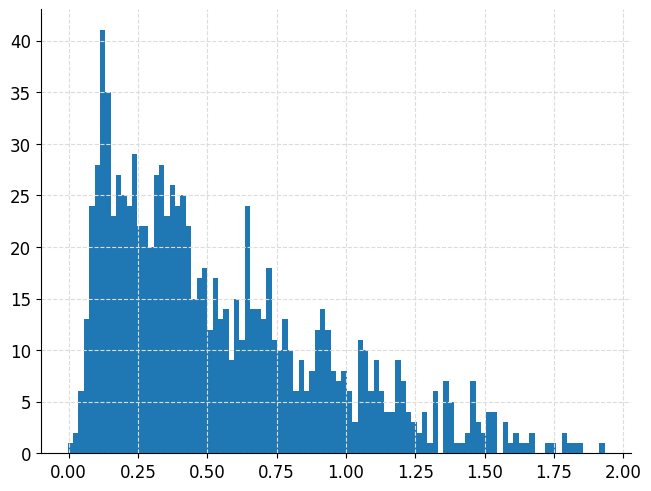

In [214]:
plt.hist(jnp.log10(M_pred_norm), 100)

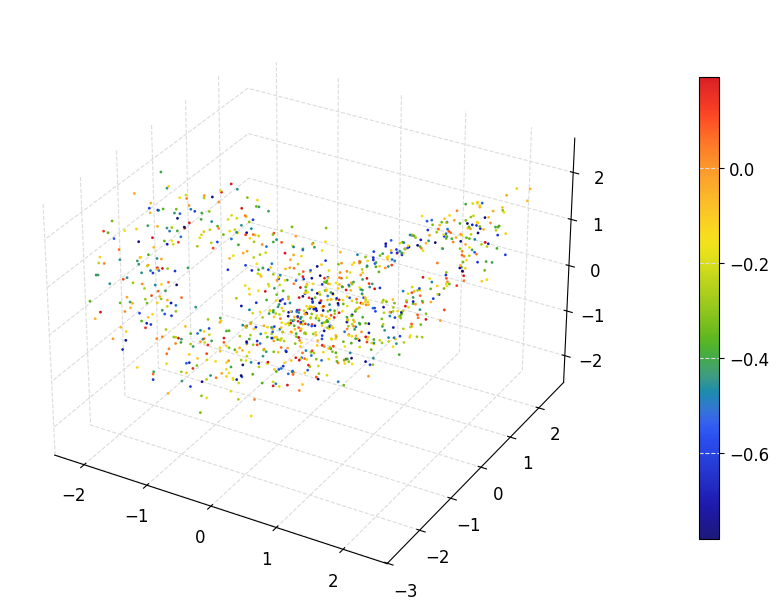

In [215]:
fig = colored_scatterplot(
    [batch[1][:, 0].T],
    [logerr],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)

In [147]:
du[:, 0].shape

(1024, 3, 30)

In [148]:
Z = jnp.concatenate((du[:, 0], du[:, 1]), axis=1)
Z.shape

(1024, 6, 30)

In [149]:
U, Sigma, Vh = jnp.linalg.svd(Z, full_matrices=False)

In [150]:
U.shape

(1024, 6, 6)

In [151]:
Sigma[1]

Array([0.25508711, 0.05544026, 0.03894287, 0.02566694, 0.02453656,
       0.01796355], dtype=float64)

In [152]:
Vh.shape

(1024, 6, 30)

In [153]:
Q = jnp.permute_dims(Vh[:, :2], axes=(0, 2, 1))
Q.shape

(1024, 30, 2)

In [154]:
du0_proj = jnp.matmul(du[:, 0], Q)
du1_proj = jnp.matmul(du[:, 1], Q)
du0_proj.shape

(1024, 3, 2)

In [155]:
M_tls = jnp.matmul(du1_proj, jnp.linalg.pinv(du0_proj))
M_tls2 = jnp.matmul(U[:, 3:, 0:3], jnp.linalg.pinv(U[:, 0:3, 0:3]))

In [156]:
U_r, Sigma_r, _ = jnp.linalg.svd(du[:, 0])
print(Sigma_r)

[[0.04577459 0.04110772 0.03402601]
 [0.04928771 0.04276527 0.02727034]
 [0.03996311 0.03020185 0.02762245]
 ...
 [0.03575314 0.03124144 0.02683338]
 [0.03520876 0.03337675 0.02591088]
 [0.05084038 0.04203693 0.02028814]]


In [157]:
U[:, 3:].shape

(1024, 3, 6)

In [158]:
M_tls2.shape

(1024, 3, 3)

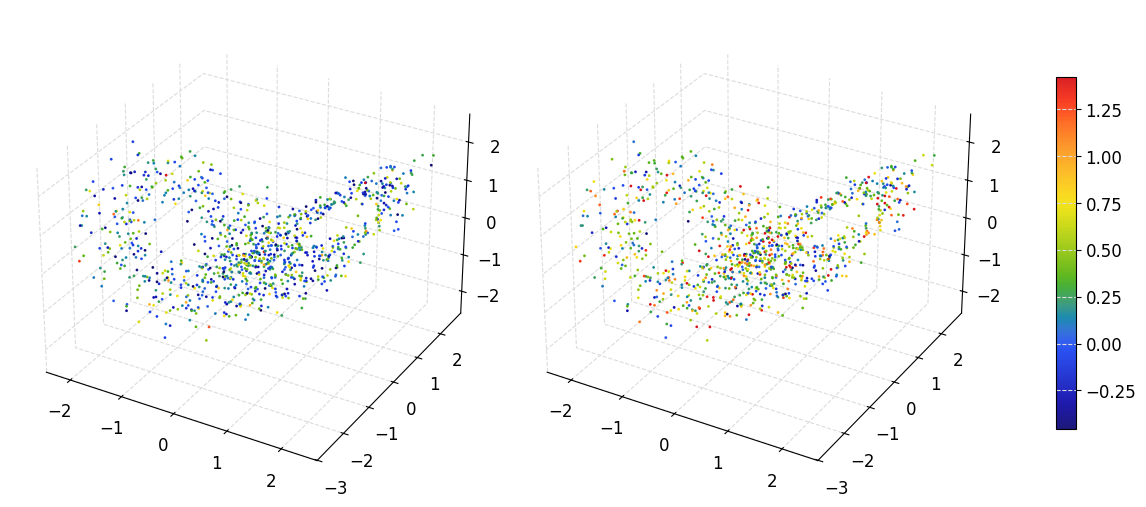

In [194]:
logerr2 = jnp.log10(
    jnp.linalg.norm(M_pred - M_tls, axis=(-2, -1), ord="fro") / M_pred_norm
)
logerr3 = jnp.log10(
    jnp.linalg.norm(M_pred - M_tls2, axis=(-2, -1), ord="fro") / M_pred_norm
)
fig = colored_scatterplot(
    [batch[1][:, 0].T] * 2,
    [logerr2, logerr3],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)

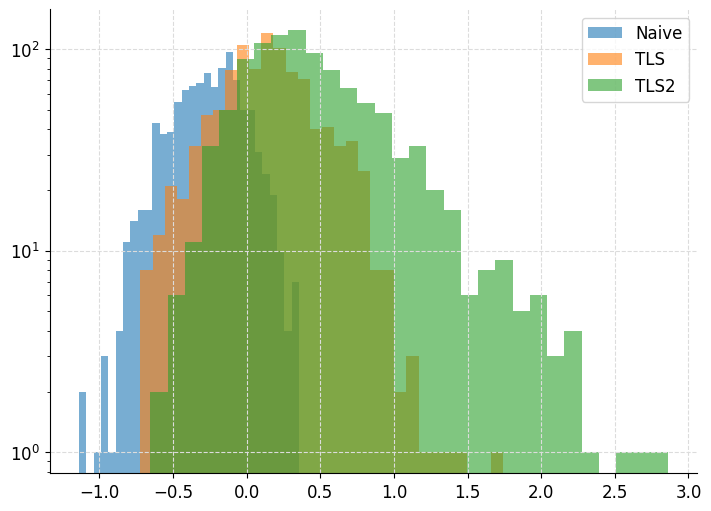

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(logerr, bins=30, label="Naive", alpha=0.6)
ax.hist(logerr2, bins=30, label="TLS", alpha=0.6)
ax.hist(logerr3, bins=30, label="TLS2", alpha=0.6)
ax.legend()
ax.set_yscale("log")

In [179]:
M_true = M_pred

(array([ 69., 315., 111.,   0.,   1.,   7., 159., 231., 108.,  23.]),
 array([-7.10377874, -6.00922238, -4.91466601, -3.82010964, -2.72555327,
        -1.63099691, -0.53644054,  0.55811583,  1.6526722 ,  2.74722857,
         3.84178493]),
 <BarContainer object of 10 artists>)

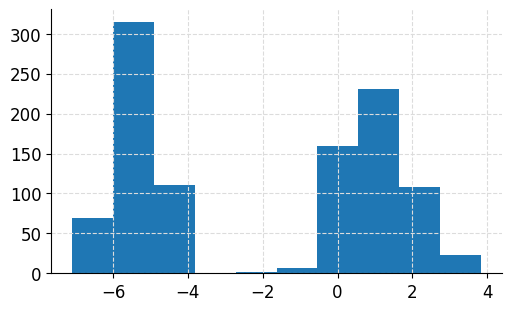

In [207]:
eig_err = (
    jnp.abs(jnp.linalg.eigvals(M_pred) - jnp.linalg.eigvals(M_tls)) ** 2
    / jnp.abs(jnp.linalg.eigvals(M_pred)) ** 2
)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(jnp.log10(jnp.abs(jnp.linalg.eigvals(M_pred)) ** 2)[:, 0])